In [2]:
!git clone https://github.com/kishkath/CIFAR10-OCP.git

Cloning into 'CIFAR10-OCP'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 53 (delta 24), reused 13 (delta 0), pack-reused 0
Unpacking objects: 100% (53/53), 16.46 KiB | 1.18 MiB/s, done.


In [3]:
import sys
sys.path.append("/content/CIFAR10-OCP/")

In [4]:
!pip install torchsummary
!pip install pytorch-gradcam
!pip install torch_lr_finder
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 47.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5265 sha256=fc8efedbc3e60b689e7dc7fd9c0686bc95af98ec2ade5d955c8d8fe58d796b6d
  Stored in directory: /root/.cache/pip/wheels/dd/3c/0e/8b7512f5d7f462c9c37342107b7f0276609345f246ae4e75fc
Successfully built pytorch-gradcam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from colorama import Fore,Style
import matplotlib.pyplot as plt
# python pip Libraries


from main import Performance,scores
from torchsummary import summary
from utils import mis_prediction,loader

from utils import class_accuracy,Plot_curves, plotting_gradCams,Draw
# user defined libraries:
# models has resnet model.
# main.py has things related to training & testing accuracies,
  ## scores returns train_acc,loss,test_acc,loss
# utils.py contain dataloading substance(loader)
  ## Plotting train-test performances and mis-classifications
  ## Plotting GRAD-CAM, deriving class wise accuracy, 
  ## getting mis-classifying list to verify if we need

==> Preparing data..
==> Getting model..
==> Its Training!


In [7]:
trainloader,testloader = loader.load_data(512)

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
## CIFAR10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
class ULTIMUS(nn.Module):
    def __init__(self,neurons=48):
        super(ULTIMUS,self).__init__() 
        self.key = nn.Linear(neurons,8)
        self.query = nn.Linear(neurons,8)
        self.value = nn.Linear(neurons,8)
        self.softmax = nn.Softmax(dim=1)
        self.out = nn.Linear(8,48) 
        
        
    def forward(self,x):
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        mul_matrix = torch.matmul(torch.transpose(q,0,1),k)
        am = self.softmax(mul_matrix)/(8**0.5)
        z = torch.matmul(v,am)
        output = self.out(z)
        
        return output
        
class Transformer(nn.Module):
    def __init__(self):
        # To not to refer base class explicity we user super().
        super(Transformer,self).__init__()
        neurons = 48
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=48,kernel_size=3,stride=1)
        
        # 26x26x48
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.ultims1 = ULTIMUS()
        self.ultims2 = ULTIMUS()
        self.ultims3 = ULTIMUS()
        self.ultims4 = ULTIMUS()
        
        self.ffc = nn.Linear(48,10)
        
        
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
       
        x = x.view(-1,48)
        x = self.ultims1(x)
        x = self.ultims2(x)
        x = self.ultims3(x)
        x = self.ultims4(x)
        x = self.ffc(x) 
        
        
        return x
            
        

In [10]:
import torch.nn.functional as F
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Transformer().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
            Conv2d-2           [-1, 32, 28, 28]           4,640
            Conv2d-3           [-1, 48, 26, 26]          13,872
 AdaptiveAvgPool2d-4             [-1, 48, 1, 1]               0
            Linear-5                    [-1, 8]             392
            Linear-6                    [-1, 8]             392
            Linear-7                    [-1, 8]             392
           Softmax-8                    [-1, 8]               0
            Linear-9                   [-1, 48]             432
          ULTIMUS-10                   [-1, 48]               0
           Linear-11                    [-1, 8]             392
           Linear-12                    [-1, 8]             392
           Linear-13                    [-1, 8]             392
          Softmax-14                   

In [12]:
from copy import deepcopy 
model1 = deepcopy(model)
model2 = deepcopy(model)

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.31E-02


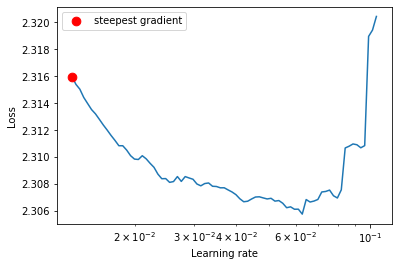

0.06278336246894335


In [13]:
from torch_lr_finder import LRFinder
import numpy as np
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01,weight_decay=0.001)

# Instantiate the LRFinder object
lr_finder = LRFinder(model2, optimizer,criterion,device="cuda")

# Run the range test
lr_finder.range_test(trainloader, end_lr=2, num_iter=200,step_mode='exp')

# Plot the learning rate versus loss curve
lr_finder.plot()

min_loss = min(lr_finder.history['loss'])
max_loss = min(lr_finder.history['loss'])
# Identify the optimal learning rate
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print(ler_rate)

In [14]:
import torch.optim as optim
device = "cuda"
from torch.optim.lr_scheduler import OneCycleLR

optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
# Define your learning rate scheduler using the OneCycleLR class
scheduler = OneCycleLR(optimizer,div_factor=25,final_div_factor=100,max_lr=0.1, epochs=20, steps_per_epoch=len(trainloader), pct_start=0.25, anneal_strategy='linear', three_phase=False,cycle_momentum=False)

# Train your neural network using the one-cycle learning rate policy
for epoch in range(20):
    print("EPOCH:", epoch)
    for p in optimizer.param_groups:
        print("Current Learning Rate: ",p["lr"])
    Performance().train(model,device, trainloader, optimizer, epoch,criterion,[False,0.001],scheduler=scheduler)
    for p in optimizer.param_groups:
        print("updated Learning Rate: ",p["lr"])
    Performance().test(model,device, testloader,epoch,criterion)


EPOCH: 0
Current Learning Rate:  0.004


Loss=2.287935972213745 Batch_id=97 train-Accuracy=13.16: 100%|██████████| 98/98 [00:15<00:00,  6.33it/s]


updated Learning Rate:  0.023239263803680982

Test set: Average loss: 0.0046, val-Accuracy: 1157/10000 (11.57%)

Saving..
EPOCH: 1
Current Learning Rate:  0.023239263803680982


Loss=2388.42626953125 Batch_id=97 train-Accuracy=10.68: 100%|██████████| 98/98 [00:14<00:00,  6.97it/s]


updated Learning Rate:  0.04247852760736197

Test set: Average loss: 29.5975, val-Accuracy: 974/10000 (9.74%)

EPOCH: 2
Current Learning Rate:  0.04247852760736197


Loss=5154895.0 Batch_id=97 train-Accuracy=9.84: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s]


updated Learning Rate:  0.061717791411042944

Test set: Average loss: 342281.3168, val-Accuracy: 1148/10000 (11.48%)

EPOCH: 3
Current Learning Rate:  0.061717791411042944


Loss=6510265344.0 Batch_id=97 train-Accuracy=10.15: 100%|██████████| 98/98 [00:13<00:00,  7.07it/s]


updated Learning Rate:  0.08095705521472393

Test set: Average loss: 16303298.3424, val-Accuracy: 1005/10000 (10.05%)

EPOCH: 4
Current Learning Rate:  0.08095705521472393


Loss=109027483648.0 Batch_id=97 train-Accuracy=10.08: 100%|██████████| 98/98 [00:13<00:00,  7.05it/s]


updated Learning Rate:  0.099932

Test set: Average loss: 153456977.9200, val-Accuracy: 912/10000 (9.12%)

EPOCH: 5
Current Learning Rate:  0.099932


Loss=1410573824.0 Batch_id=97 train-Accuracy=10.47: 100%|██████████| 98/98 [00:14<00:00,  6.83it/s]


updated Learning Rate:  0.093268

Test set: Average loss: 1233320.8576, val-Accuracy: 1417/10000 (14.17%)

Saving..
EPOCH: 6
Current Learning Rate:  0.093268


Loss=659546688.0 Batch_id=97 train-Accuracy=9.03: 100%|██████████| 98/98 [00:14<00:00,  6.92it/s]


updated Learning Rate:  0.086604

Test set: Average loss: 1134319.5200, val-Accuracy: 881/10000 (8.81%)

EPOCH: 7
Current Learning Rate:  0.086604


Loss=43640660.0 Batch_id=97 train-Accuracy=9.93: 100%|██████████| 98/98 [00:14<00:00,  6.97it/s]


updated Learning Rate:  0.07994000000000001

Test set: Average loss: 55832.3360, val-Accuracy: 1013/10000 (10.13%)

EPOCH: 8
Current Learning Rate:  0.07994000000000001


Loss=1886350.875 Batch_id=97 train-Accuracy=10.26: 100%|██████████| 98/98 [00:14<00:00,  6.97it/s]


updated Learning Rate:  0.07327600000000001

Test set: Average loss: 29203.8612, val-Accuracy: 921/10000 (9.21%)

EPOCH: 9
Current Learning Rate:  0.07327600000000001


Loss=19064446.0 Batch_id=97 train-Accuracy=10.39: 100%|██████████| 98/98 [00:14<00:00,  6.91it/s]


updated Learning Rate:  0.066612

Test set: Average loss: 22985.0389, val-Accuracy: 921/10000 (9.21%)

EPOCH: 10
Current Learning Rate:  0.066612


Loss=226216176.0 Batch_id=97 train-Accuracy=10.02: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]


updated Learning Rate:  0.059948

Test set: Average loss: 285493.5136, val-Accuracy: 1342/10000 (13.42%)

EPOCH: 11
Current Learning Rate:  0.059948


Loss=18379518.0 Batch_id=97 train-Accuracy=11.71: 100%|██████████| 98/98 [00:14<00:00,  6.95it/s]


updated Learning Rate:  0.053284000000000005

Test set: Average loss: 16882.9915, val-Accuracy: 841/10000 (8.41%)

EPOCH: 12
Current Learning Rate:  0.053284000000000005


Loss=130003968.0 Batch_id=97 train-Accuracy=10.63: 100%|██████████| 98/98 [00:14<00:00,  6.94it/s]


updated Learning Rate:  0.046619999999999995

Test set: Average loss: 195431.4832, val-Accuracy: 601/10000 (6.01%)

EPOCH: 13
Current Learning Rate:  0.046619999999999995


Loss=1458020.0 Batch_id=97 train-Accuracy=10.37: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s]


updated Learning Rate:  0.039956

Test set: Average loss: 2311.4153, val-Accuracy: 1276/10000 (12.76%)

EPOCH: 14
Current Learning Rate:  0.039956


Loss=1794103.375 Batch_id=97 train-Accuracy=11.04: 100%|██████████| 98/98 [00:14<00:00,  6.86it/s]


updated Learning Rate:  0.033292

Test set: Average loss: 3656.7760, val-Accuracy: 1356/10000 (13.56%)

EPOCH: 15
Current Learning Rate:  0.033292


Loss=73944.9140625 Batch_id=97 train-Accuracy=10.38: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]


updated Learning Rate:  0.026628

Test set: Average loss: 22563.0174, val-Accuracy: 1089/10000 (10.89%)

EPOCH: 16
Current Learning Rate:  0.026628


Loss=27175356.0 Batch_id=97 train-Accuracy=10.64: 100%|██████████| 98/98 [00:14<00:00,  6.86it/s]


updated Learning Rate:  0.019963999999999996

Test set: Average loss: 33383.8593, val-Accuracy: 1373/10000 (13.73%)

EPOCH: 17
Current Learning Rate:  0.019963999999999996


Loss=1509794.0 Batch_id=97 train-Accuracy=11.15: 100%|██████████| 98/98 [00:14<00:00,  6.86it/s]


updated Learning Rate:  0.013300000000000006

Test set: Average loss: 5058.7968, val-Accuracy: 1382/10000 (13.82%)

EPOCH: 18
Current Learning Rate:  0.013300000000000006


Loss=765882.9375 Batch_id=97 train-Accuracy=10.81: 100%|██████████| 98/98 [00:14<00:00,  6.98it/s]


updated Learning Rate:  0.006636000000000003

Test set: Average loss: 1418.1347, val-Accuracy: 1331/10000 (13.31%)

EPOCH: 19
Current Learning Rate:  0.006636000000000003


Loss=39987.0703125 Batch_id=97 train-Accuracy=10.79: 100%|██████████| 98/98 [00:14<00:00,  6.97it/s]


updated Learning Rate:  -2.8000000000000247e-05

Test set: Average loss: 84.6693, val-Accuracy: 972/10000 (9.72%)



array([[<AxesSubplot:title={'center':'Training Loss'}>,
        <AxesSubplot:title={'center':'Test Loss'}>],
       [<AxesSubplot:title={'center':'Training Accuracy'}>,
        <AxesSubplot:title={'center':'Test Accuracy'}>]], dtype=object)

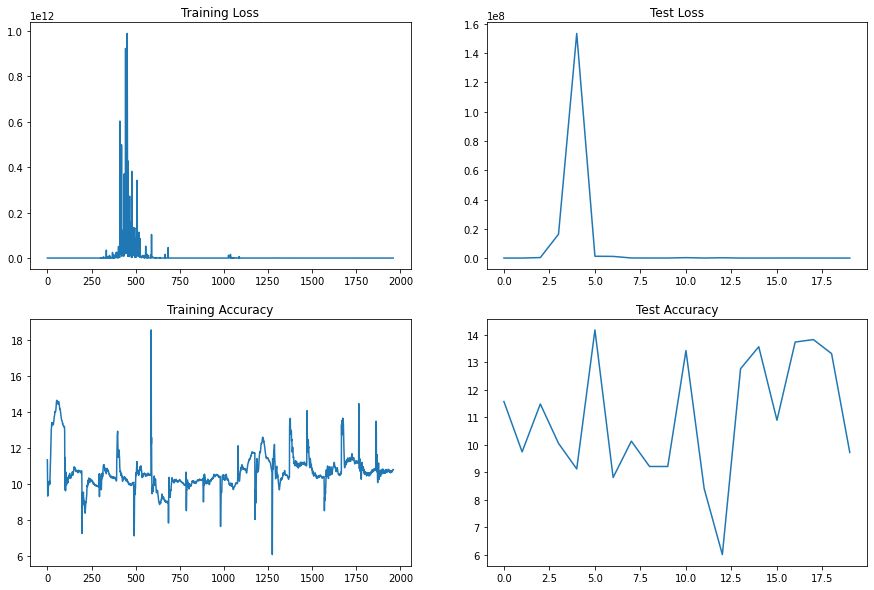

In [15]:
## Performance scores
train_acc,train_losses,test_acc,test_losses = scores()
Plot_curves().performance_curves(train_acc,test_acc,train_losses,test_losses)

                              MISCLASSIFIED IMAGES                              




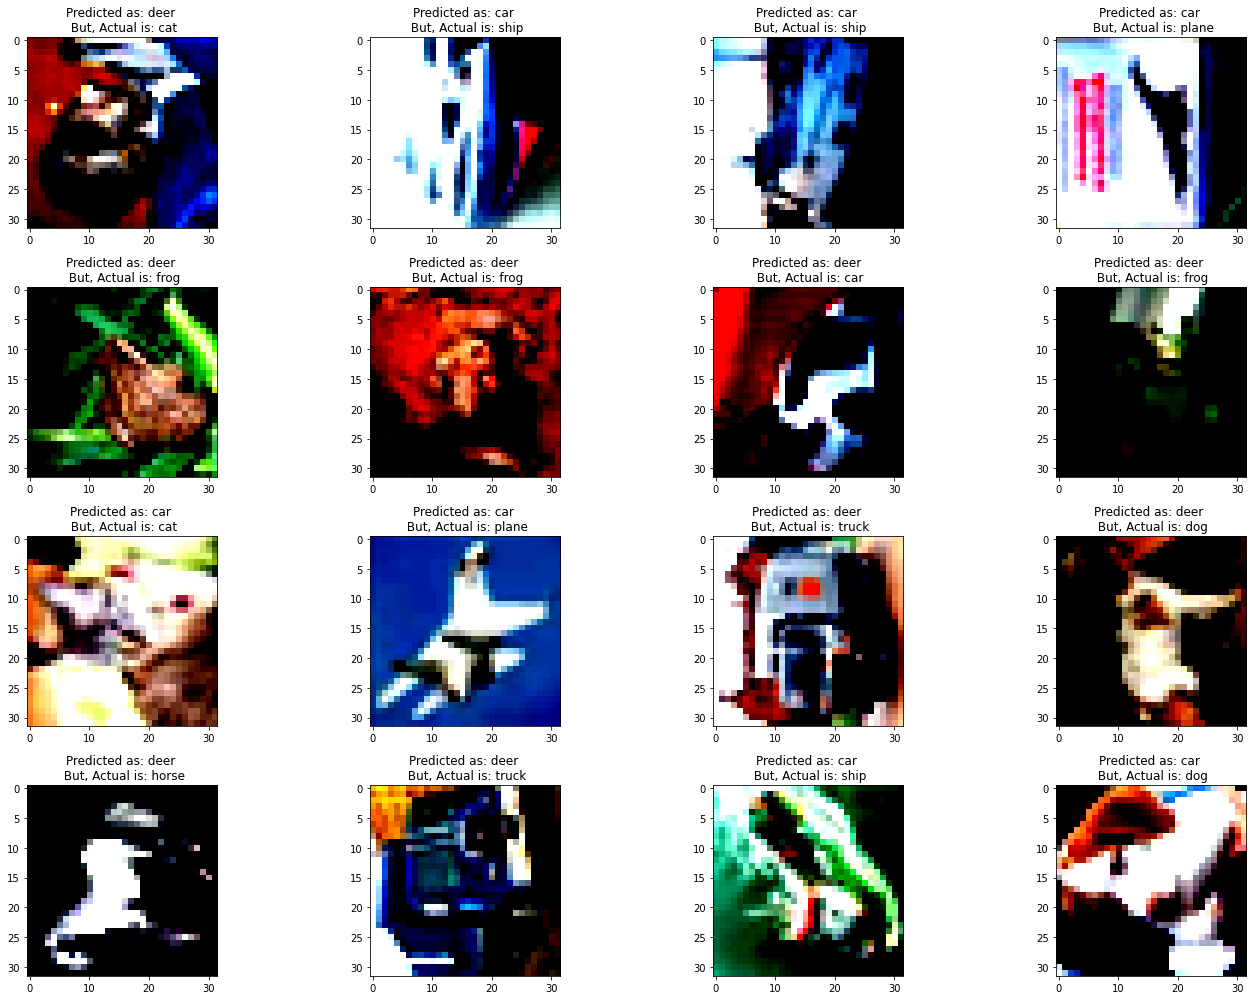

In [16]:
print(" "*30+Style.BRIGHT+Fore.BLACK+"MISCLASSIFIED IMAGES"+" "*30)
print("\n")
# If you want n number of images to plot just pass the number as third parameter:
# like: mis_classsified(model,testloader,7,default is 10
Plot_curves.mis_classified(model,testloader,16)

                    GRAD-CAM usable diagnosistic IMAGES                    
Diagnosis is happening for Layer2 of ResNet18. Lets go!


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


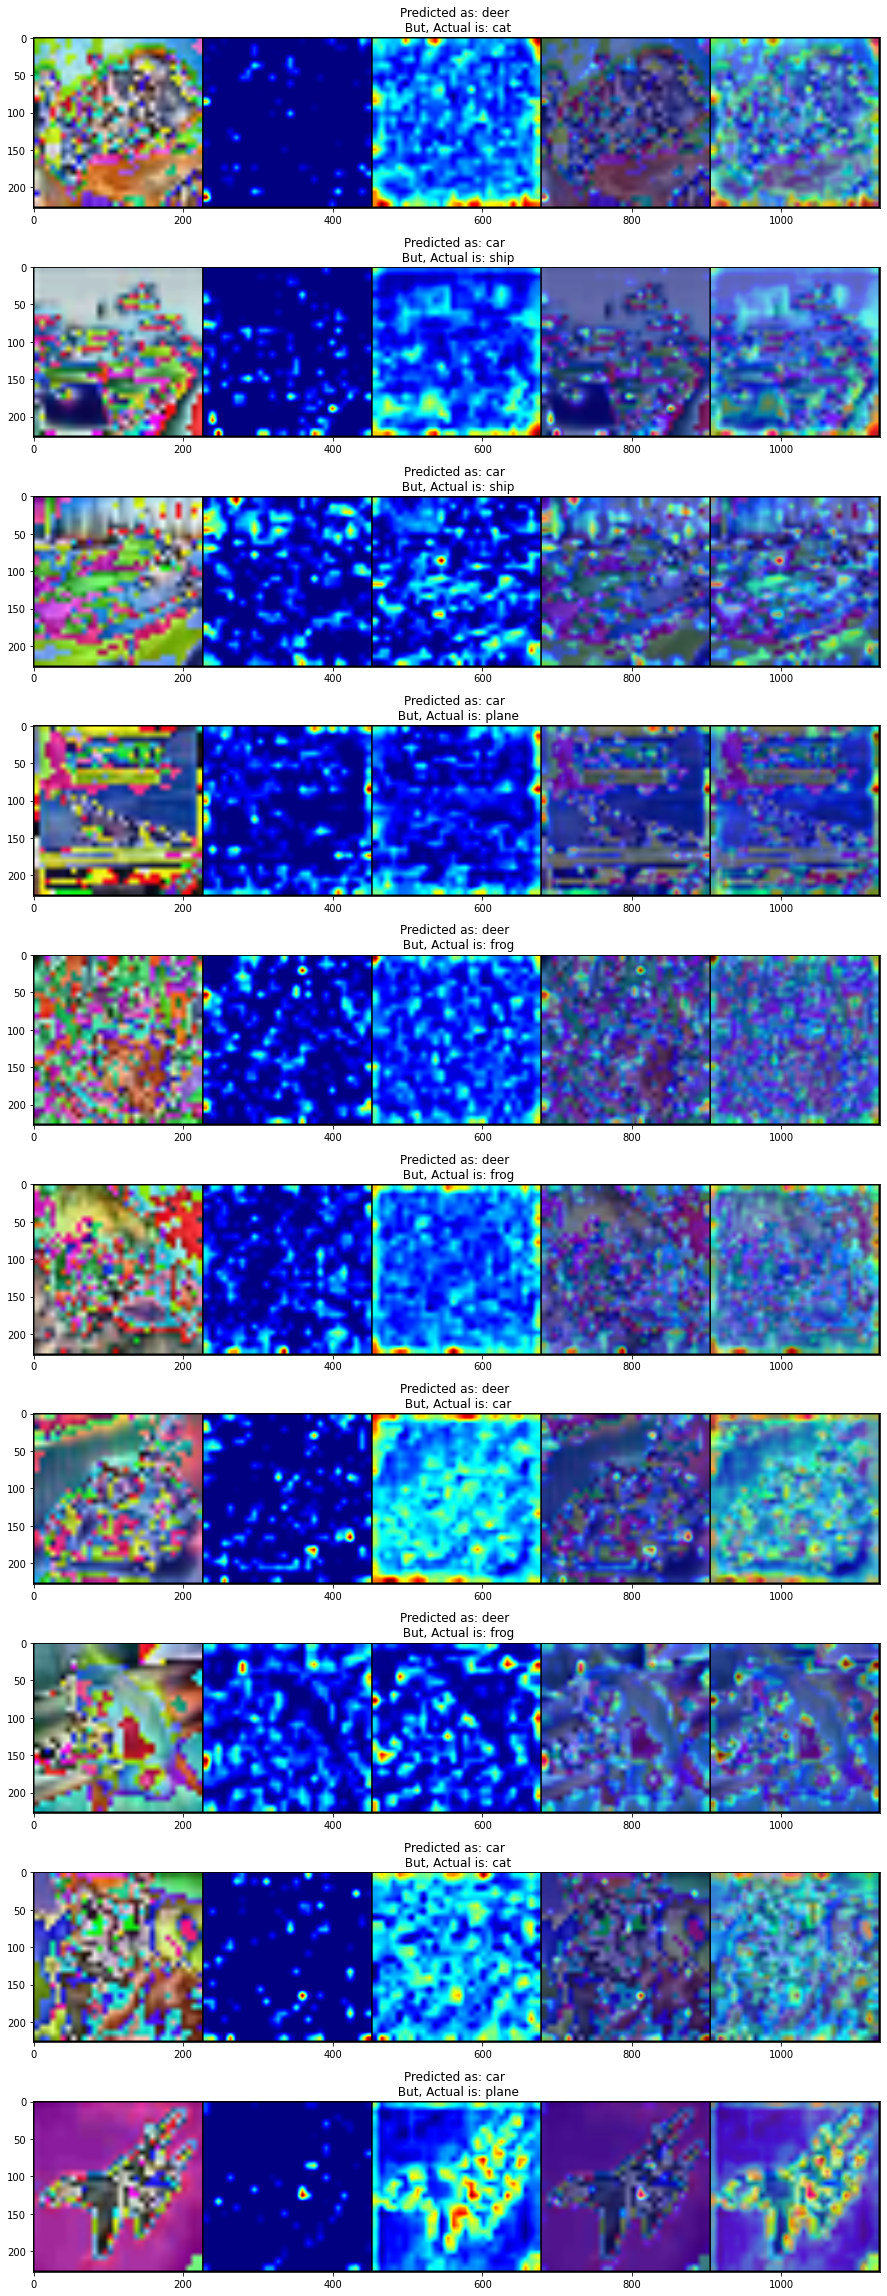

In [17]:
## Can plots any number of images less than stored mis-classifed Images
print(" "*20+Style.BRIGHT+Fore.BLACK+"GRAD-CAM usable diagnosistic IMAGES"+" "*20)
plotting_gradCams(10)

In [18]:
print("Done, Not the best performing Architecture!")

Done, Not the best performing Architecture!
